In [17]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, SnapshotObjectType, OperationStatusType

In [18]:
import matplotlib.pyplot as plt

In [19]:
# Set the FACE_SUBSCRIPTION_KEY environment variable with your key as the value.
# This key will serve all examples in this document.
KEY = os.environ['FACE_SUBSCRIPTION_KEY']
# Set the FACE_ENDPOINT environment variable with the endpoint from your Face service in Azure.
# This endpoint will be used in all examples in this quickstart.
ENDPOINT = os.environ['FACE_ENDPOINT']

In [20]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [21]:
os.listdir("/Volumes/GoogleDrive/Shared drives/Facefortrainning")

['17', '15', '4', '13', '12', '10', '3', 'Icon\r']

In [25]:
PERSON_GROUP_ID = 'demo1'

In [26]:
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

Person group: demo1


In [7]:
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

In [27]:
dict_user={}

In [31]:
dict_user

{'1a8d4b0f-bd6f-43a2-a9dd-0ed93f388f15': '17',
 '802c64ba-1e1e-4ad1-8dd2-71f7f7b23687': '15',
 '909efec8-6673-4b88-961a-09eb26d7ccd3': '4',
 '366a76da-b584-40e4-ab79-5d14b438df15': '13',
 '720915a2-b280-4ecd-8a38-d0f175782678': '12',
 '94390c1c-0353-48b2-b335-ef3535764315': '10',
 'dc112880-8f5c-4ad2-af19-76e2639d9e9b': '3',
 'b9bb6fc1-6bab-43fc-855c-0194dae032c2': 'Icon\r'}

In [ ]:
w = open(pathofphoto, 'r+b')
detected_faces = face_client.face.detect_with_stream(w)
time.sleep(10)

17
301 183 655 537


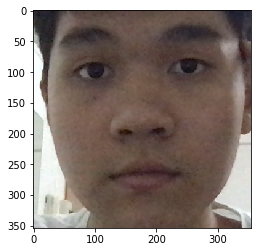

429 171 738 480


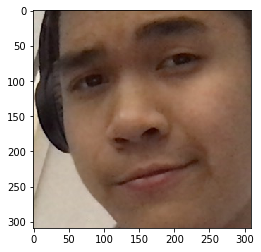

15
398 226 618 446


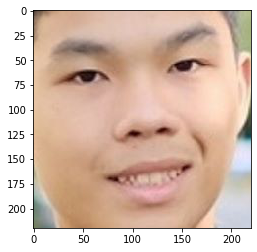

348 583 789 1024


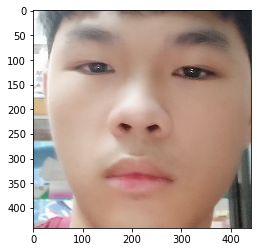

125 828 797 1500


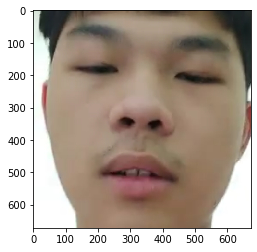

407 468 717 778


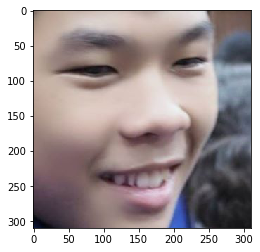

199 461 705 967


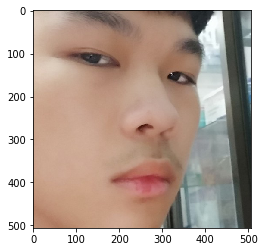

4
286 244 405 363


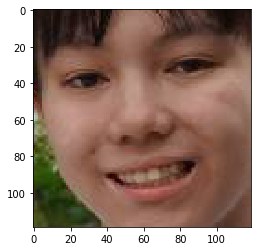

583 385 883 685


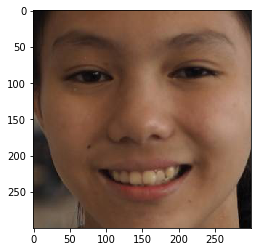

470 295 585 410


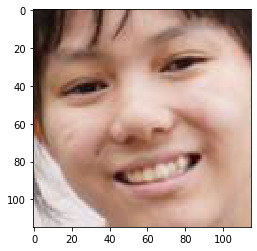

444 1096 700 1352


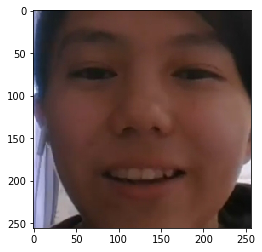

13
12
10
1173 743 1445 1015


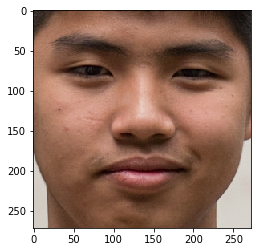

3
485 1028 745 1288


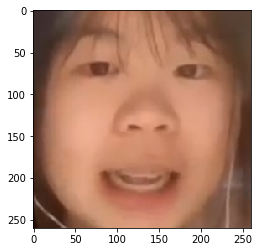

Icon


NotADirectoryError: [Errno 20] Not a directory: '/Volumes/GoogleDrive/Shared drives/Facefortrainning/Icon\r'

In [29]:
for name in os.listdir("/Volumes/GoogleDrive/Shared drives/Facefortrainning"):
    dirofname="/Volumes/GoogleDrive/Shared drives/Facefortrainning/"+name
    print(name)
    person_group_person = face_client.person_group_person.create(PERSON_GROUP_ID, name)
    list_img=[]
    dict_user[person_group_person.person_id]=name
    for photo in os.listdir(dirofname):
        if(photo[-4:]!=".jpg"):
            continue
        pathofphoto=dirofname+"/"+photo
        w = open(pathofphoto, 'r+b')
        detected_faces = face_client.face.detect_with_stream(w)
        time.sleep(10)
        if not detected_faces:
            raise Exception('No face detected from image')
            continue
        for face in detected_faces:
            ((left, top), (right, bottom))=getRectangle(face)
        print(left, top, right, bottom)
        img = Image.open(pathofphoto)
        img=img.crop((left, top, right, bottom))
        plt.imshow(img)
        plt.show()
        list_img.append(img)
    for i in list_img:
        i.save("temp.jpg")
        w = open("temp.jpg", 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, person_group_person.person_id, w)
        time.sleep(10)

In [30]:
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)


Training the person group...
Training status: succeeded.



In [ ]:
'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
group_photo = 'test-image-person-group.jpg'
IMAGES_FOLDER = os.path.join(os.path.dirname(os.path.realpath("__file__")),"Officail_samples")

# Get test image
test_image_array = glob.glob(os.path.join(IMAGES_FOLDER, group_photo))
image = open(test_image_array[0], 'r+b')

# Detect faces
face_ids = []
faces = face_client.face.detect_with_stream(image)
for face in faces:
    face_ids.append(face.face_id)

In [ ]:
# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in {}'.format(os.path.basename(image.name)))
if not results:
    print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
for person in results:
    print('Person for face ID {} is identified in {} with a confidence of {}.'.format(person.face_id, os.path.basename(image.name), person.candidates[0].confidence)) # Get topmost confidence score